A través de la biblioteca **email**, se seleccionan todos los "body" incluidos en cada uno de los archivos del repositorio y se concatenan en un solo archivo: **email_body.txt** 

In [4]:
import os
import git
from email.parser import Parser

rootdir = '/workspaces/Enronsent_Dataset/'

def email_analyse(inputfile, email_body):
    with open(inputfile, "r") as f:
        data = f.read()

    email = Parser().parsestr(data)
    
    email_body.append(email.get_payload())

email_body = []

for directory, subdirectory, filenames in os.walk(rootdir):
    for filename in filenames:
        try:
            email_analyse(os.path.join(directory, filename), email_body)
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

with open("email_body.txt", "w") as f:
    for email_bod in email_body:
        if email_bod:
            f.write(str(email_bod))

Error processing file index: 'utf-8' codec can't decode bytes in position 13-14: invalid continuation byte
Error processing file pack-587d0ab4b2e98cd78abe6cce4ec6a595bae19187.idx: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
Error processing file pack-587d0ab4b2e98cd78abe6cce4ec6a595bae19187.pack: 'utf-8' codec can't decode byte 0x91 in position 12: invalid start byte


a partir de Analisis Exploratorio de Datos (el cual se mostrará posteriormente) se identifica que en el documento generado email_body.txt  existe información que genera ruido y debe ser limpiada. Por lo cual se implementó el siguiente tratamiento con ayuda de la biblioteca **re**

In [5]:
import re

def clean_email_text(filename, new_filename):

    un_words_1 = ["Thanks for your time","hope to see you","see you there","Looking forward to your feedback","regards","best regards"]
    un_words_2 = ['Return-Path','Received','X-MimeOLE',"charset","attachment; filename","quoted-printable","mailto",'Message-Id',"The original message was received at",'Content-','MIME-','by postmaster',"X-MS","Thread-","X-mailer","X-sender","X-Authentication",'Get your FREE download']
    un_words_3 = ['Host unknown','intermail','SMTP','base64','Copyright']
    
    with open(filename, 'r', encoding='utf-8') as file, open(new_filename, 'w', encoding='utf-8') as outfile:
        
        All_txt = file.read()
        
        # Limpieza
        line = re.sub(r'=\n', '', All_txt)# Eliminar "=" seguido de un salto de línea
        line = re.sub(r'^.*\t\s+\bPST\b\t\s+.*\n', ' ', line, flags=re.IGNORECASE | re.MULTILINE)
        line = re.sub(r'The following section of this message[\s\S]*?\n\n', ' ', line, flags=re.IGNORECASE | re.MULTILINE)
        line = re.sub(r'This message is for the[\s\S]*?\n\n', ' ', line, flags=re.IGNORECASE | re.MULTILINE)
        line = re.sub(r'This message may contain[\s\S]*?\n\n', ' ', line, flags=re.IGNORECASE | re.MULTILINE)
        line = re.sub(r'This email and any files[\s\S]*?\n\n', ' ', line, flags=re.IGNORECASE | re.MULTILINE)
        line = re.sub(r'This\s+e-mail is the property of Enron\s+Corp\.[\s\S]*?Thank you', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'this email may contain[\s\S]*?\n\n', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'^This email message is for the sole use[\s\S]*?\bLLP\b', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'Privileged/Confidential[\s\S]*?consent\s*to', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'The information contained in this transmission[\s\S]*?original message\.', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'contain confidential and privileged information[\s\S]*?original message\.', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'Please click on the link below to indicate[\s\S]*?Return\.', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'The information transmitted is[\s\S]*?computer\.', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'The information transmitted is[\s\S]*?computers\.', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'PG&E National Energy Group and any other[\s\S]*?\n\n', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'The following expense report[\s\S]*?Expense\.', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'\*{1,40}NOTICE\*{1,40}[\s\S]*?Thank you\.', ' ', line, flags=re.IGNORECASE)
        line = re.sub(r'This e-mail message may contain legally privileged and/or confidential[\s\S]*?from\s+your\s+computer\.', ' ', line, flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'To reply to our[\s\S]*?\n\n', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'CONFIDENTIALITY NOTICE[\s\S]*?\n\n', ' ', line, flags=re.IGNORECASE|re.MULTILINE)
        line = re.sub(r'CONFIDENTIAL:[\s\S]*?\n\n', ' ', line, flags=re.IGNORECASE|re.MULTILINE)
        line = re.sub(r'This e-mail, including[\s\S]*?\n\n', ' ', line,flags=re.MULTILINE | re.IGNORECASE)
        line = re.sub(r'Internet Email[\s\S]*?\n\n', ' ', line, flags=re.IGNORECASE|re.MULTILINE)
        line = re.sub(r'\-{3,15}.+?\-{3,15}\n?', ' ', line) # Eliminar mensajes de rebote u otros patrones
        line = re.sub(r'http[^\s\n]+', ' ', line, flags=re.IGNORECASE|re.MULTILINE)
        line = re.sub(r'<.*?>.*\n', ' ', line)  # Eliminar etiquetas HTML
        line = re.sub(r'\b(?:' + '|'.join(map(re.escape, un_words_1)) + r')\b', ' ', line, flags=re.IGNORECASE) #Eliminar palabras de la lista un_words_1
        line = re.sub(r'.*\[\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\].*\n?',' ' , line) #Eliminar líneas con direcciones IP
        line = re.sub(r'~~~~|====[^\n]*\n', ' ', line, flags=re.MULTILINE)
        line = re.sub(r'[^\w\n]{3,}\n', ' ', line, flags=re.MULTILINE)
        line = re.sub(r'@enron.com|@enron', '@', line, flags=re.IGNORECASE) # Borrar el Dominio Enron de los correos electronicos
        line = re.sub(r'^(' + '|'.join(un_words_2) + r').*\n?', '', line, flags=re.MULTILINE | re.IGNORECASE) #Eliminar palabras de la lista un_words_2
        line = re.sub(r'^\s+', '' , line, flags=re.MULTILINE) #Eliminar cualquier espacio en blanco existente al comienzo de cada linea
        line = re.sub(r'^>', '', line, flags=re.MULTILINE) #Eliminar las líneas que comienzan con ">"
        line = re.sub(r'^.*(' + '|'.join(un_words_3) + r').*\n?', '', line, flags=re.MULTILINE  | re.IGNORECASE) #Eliminar palabras de la lista un_words_3 
                        
        outfile.write(line)
        
clean_email_text('email_body.txt', 'Clean_email_body.txt')

En el trabajo de limpieza realizado se atacaron diversidad de información contenida en los correos, correspondiente a mensajes de confidencialidad, muy tipicos de una firma de correo en una corporación (no solo de la corporación Enron, ya que también se incluyeron mensajes provenientes de otras corporaciones, a las cuales la corp enron les daba respuesta). Se realizó un analisis del texto encontrado con estas caracterisiticas y se parametrizó en el codigo para que se eliminara de una manera justa (solamente el mensaje de confidencialidad), a fin de no afectar la información incluida en el cuerpo del mensaje, que es precismanete el texto que se quiere analizar. Se eliminaron también patrones muy tipicos de mensajes de rebote, de correo spam, direcciones de internet, codigo HTML, "tablas de datos númericos"  entre otros que fueron identificados generando ruido. La creación de las listas fue un diseño que segmento 3 grupos de palabras diferentes y es de utilidad por si se requieren agregar más palabras a las listas, a cada grupo de palabras se le realiza un tratamiento de limpieza diferente. Es importante precisar que el trabajo de limpieza de los datos influye de manera directa en el posterior analisis por lo cual, entre más limpio se encuentre el archivo mejor será el analisis de datos.

# EDA #

Todo el trabajo realizado anteriormente ya se encuentra almacenado en el documento **Clean_email_body.txt** el cual se encuentra almacenado en la ruta:  '/workspaces/Enronsent_Dataset/Clean_email_body.txt'.

Dentro de esta sección se definiran funciones, a las cuales se les cargara el documento previamente generado, a fin de obtener la información a analizar.

## 1. Preprocesamiento de Texto ##

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import bigrams, trigrams, ngrams
from collections import Counter

In [10]:
# stopwords se carga por unica vez y se convierte en un conjunto
stop_words_set = set(stopwords.words('english'))

# Función de Conteo de palabras
def word_count(filename):
    f = Counter()
    with open(filename, "r", encoding = 'utf-8') as file:
        for line in file:
            #Se usan expresiones regulares para dividir el texto en palabras,
            # así como la conversión de todas las palabras a minusculas.
            words = re.findall(r'\w+', line.lower())
            filtered_words = [word for word in words if word.isalpha() and word not in stop_words_set]
            f.update(filtered_words)
    return f

# Función de lematizador
lemmatizer = WordNetLemmatizer()
def lemmatize_text(filename):
    # Lista para almacenar el texto lematizado
    text = []
    with open(filename, "r", encoding='utf-8') as file:
        for line in file:
            words = re.findall(r'\w+', line.lower())
            filtered_words = [word for word in words if word.isalpha() and word not in stop_words_set]
            lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
            # Unir las palabras lematizadas para formar el mensaje
            text.append(' '.join(lemmatized_words))
    return text

# Función de creación/conteo de n-gramas: 
def count_ngrams(filename, n=2):
    frecuencia = Counter()
        
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            words = re.findall(r'\w+', line.lower())
            # Filtrar palabras no alfabéticas y stopwords
            filtered_words = [word for word in words if word.isalpha() and word not in stop_words_set]
            
            # Crear n-gramas
            if n == 2:
                n_grams = bigrams(filtered_words)
            elif n == 3:
                n_grams = trigrams(filtered_words)
            else:
                n_grams = ngrams(filtered_words, n)
       
            frecuencia.update([' '.join(gram) for gram in n_grams])
    return frecuencia

# Función de Matriz Co-ocurrencia
def co_occurrence_matrix(filename, n=2):
    co_occurrence = Counter()

    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            words = re.findall(r'\w+', line.lower())
            filtered_words = [word for word in words if word.isalpha() and word not in stop_words_set]

            # Crear n-gramas
            n_grams = list(ngrams(filtered_words, n))

            # Actualizar la matriz de co-ocurrencia
            for gram in n_grams:
                co_occurrence.update(gram)
    return co_occurrence

### Visualización de las funciones y creación de variables:

In [11]:
word_frequency = word_count('Clean_email_body.txt')
unique_words = list(word_frequency.keys())  # Obtener las claves (palabras únicas)
text = lemmatize_text('Clean_email_body.txt')
word_counter = Counter(text)
bigram_frequency= count_ngrams('Clean_email_body.txt', 2)
trigram_frequency = count_ngrams('Clean_email_body.txt', 3) 
ngram_frequency= count_ngrams('Clean_email_body.txt', 5)
result_matrix= co_occurrence_matrix('Clean_email_body.txt', 5)

In [18]:
#las primeras 10 palabras junto a su frecuencia:
dict(list(word_frequency.items())[:10])

{'dying': 76,
 'see': 16227,
 'soon': 5535,
 'pam': 288,
 'macaul': 4,
 'information': 13709,
 'developer': 150,
 'attached': 15255,
 'file': 5556,
 'gif': 173}

#### WordCloud

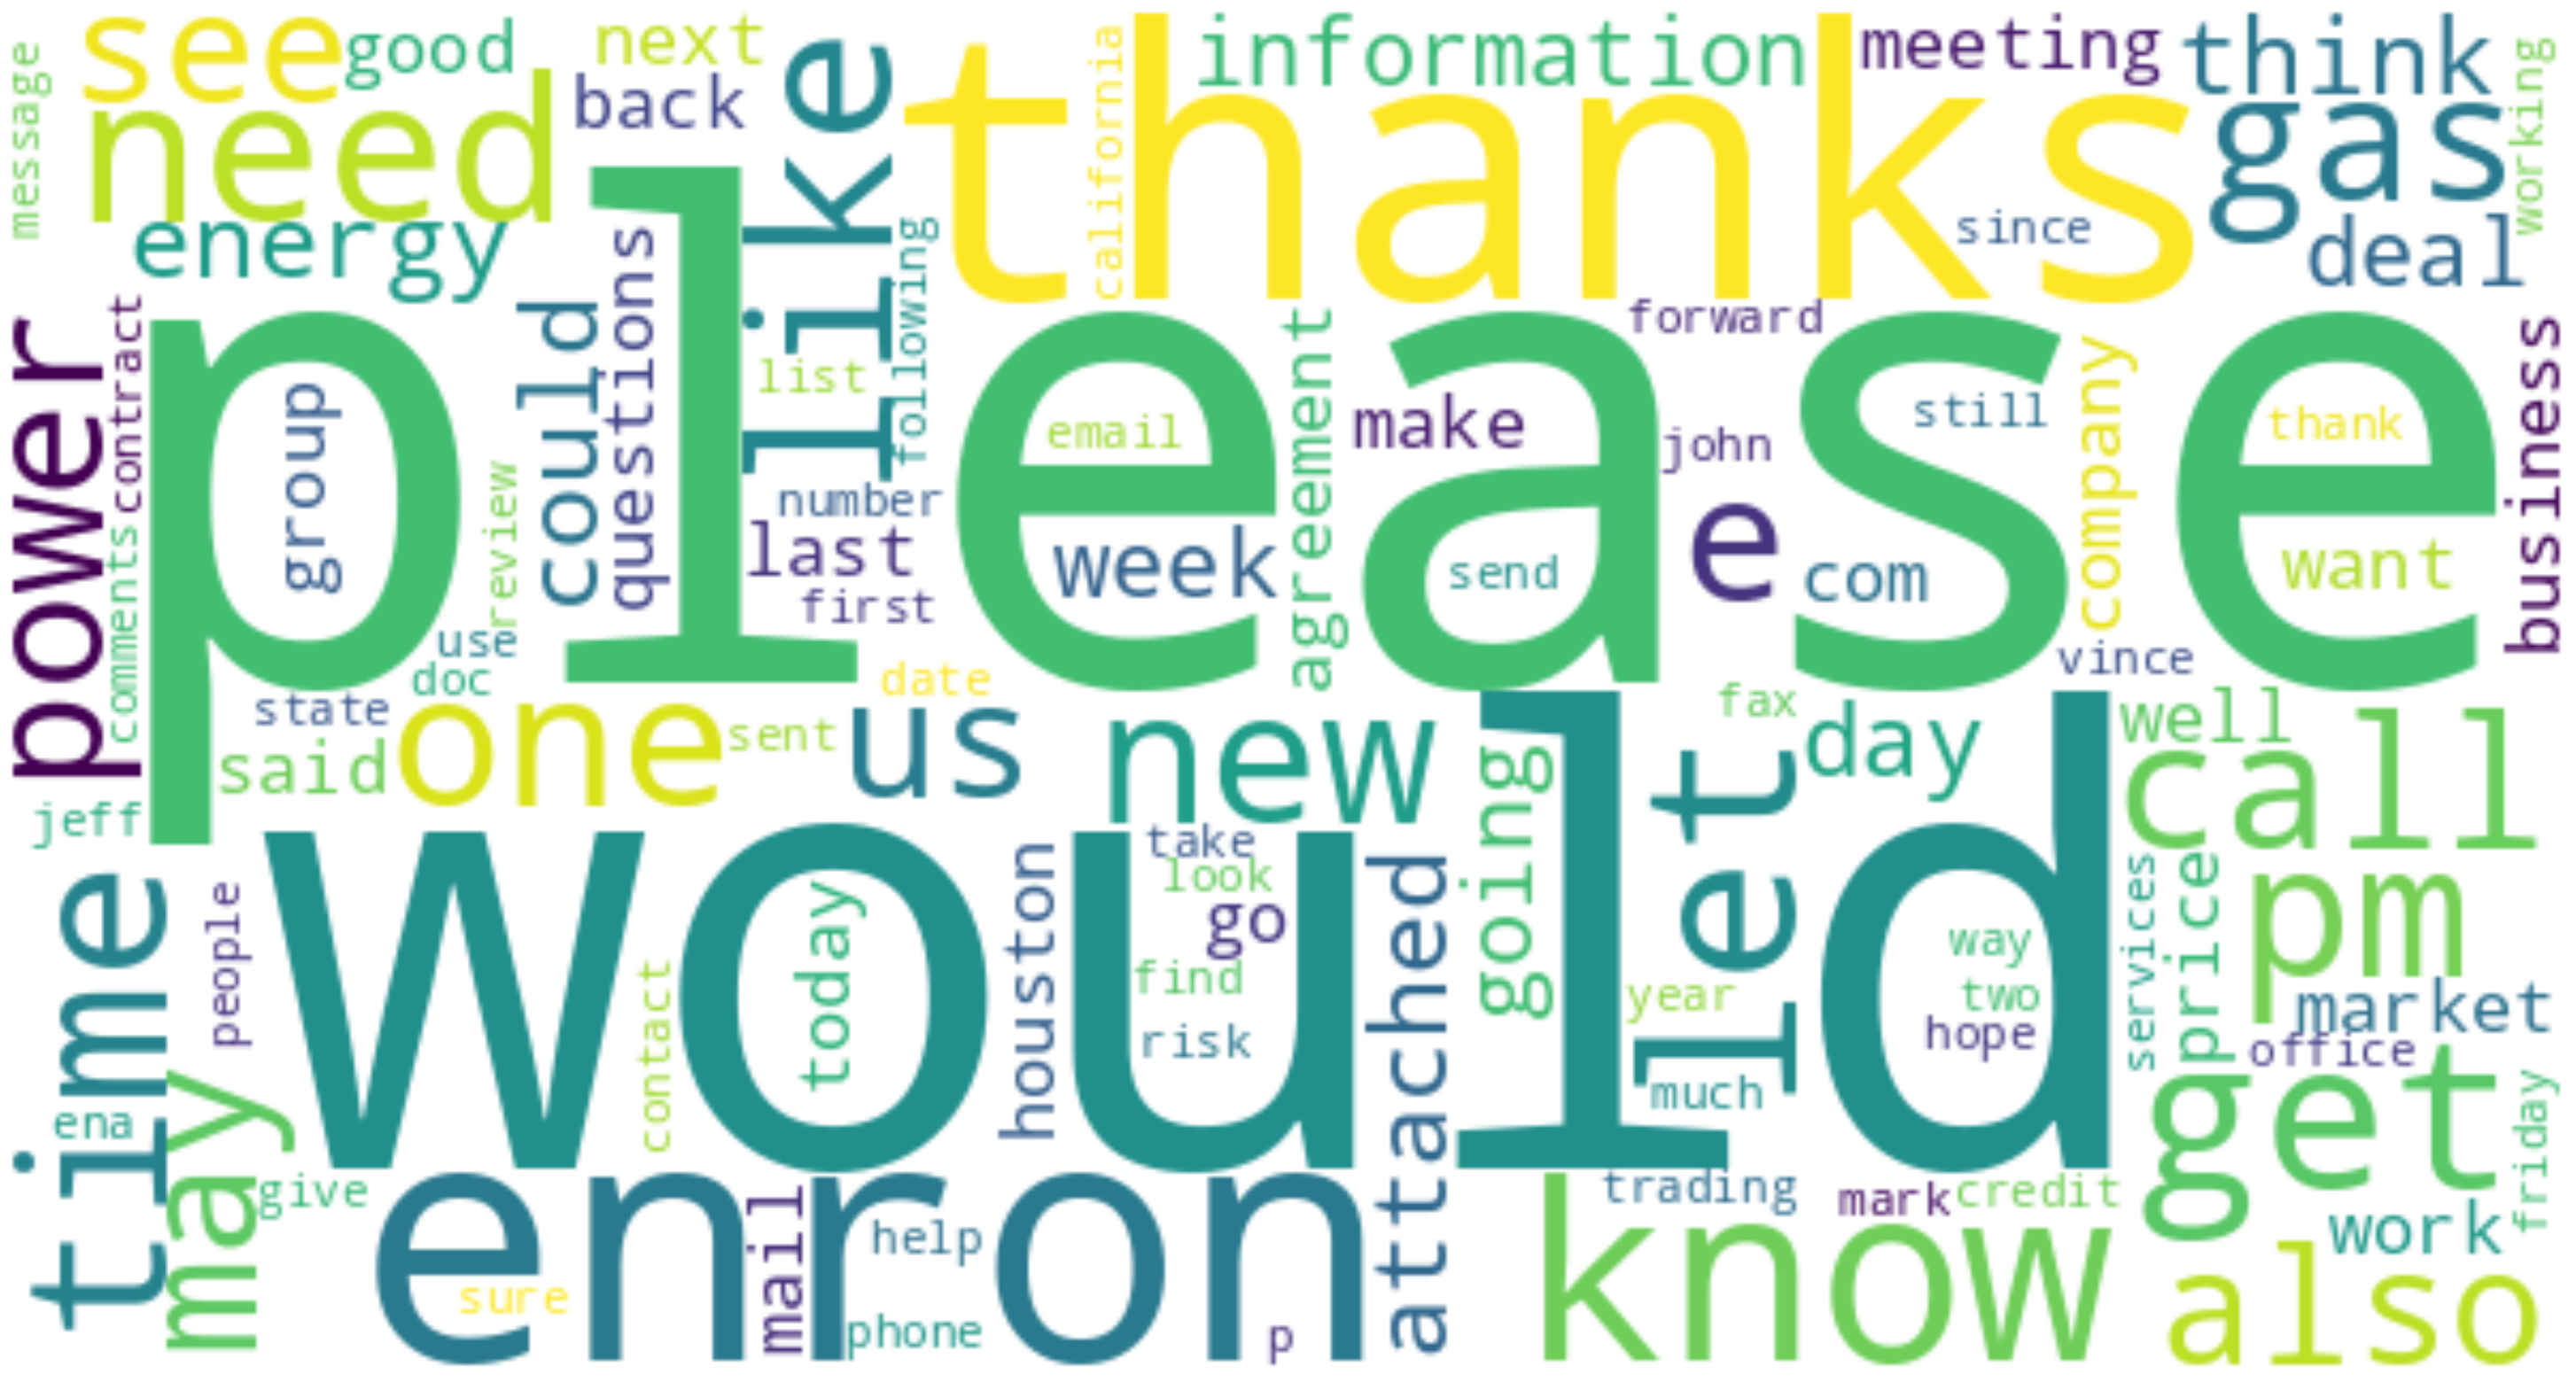

In [5]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Crear una Word Cloud
wordcloud = WordCloud(width=600, height=320, background_color='white').generate_from_frequencies(dict(word_frequency.most_common(100)))

# Mostrar la Word Cloud
plt.figure(figsize=(60, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Matriz y Red de Co-ocurrencia (n=5)

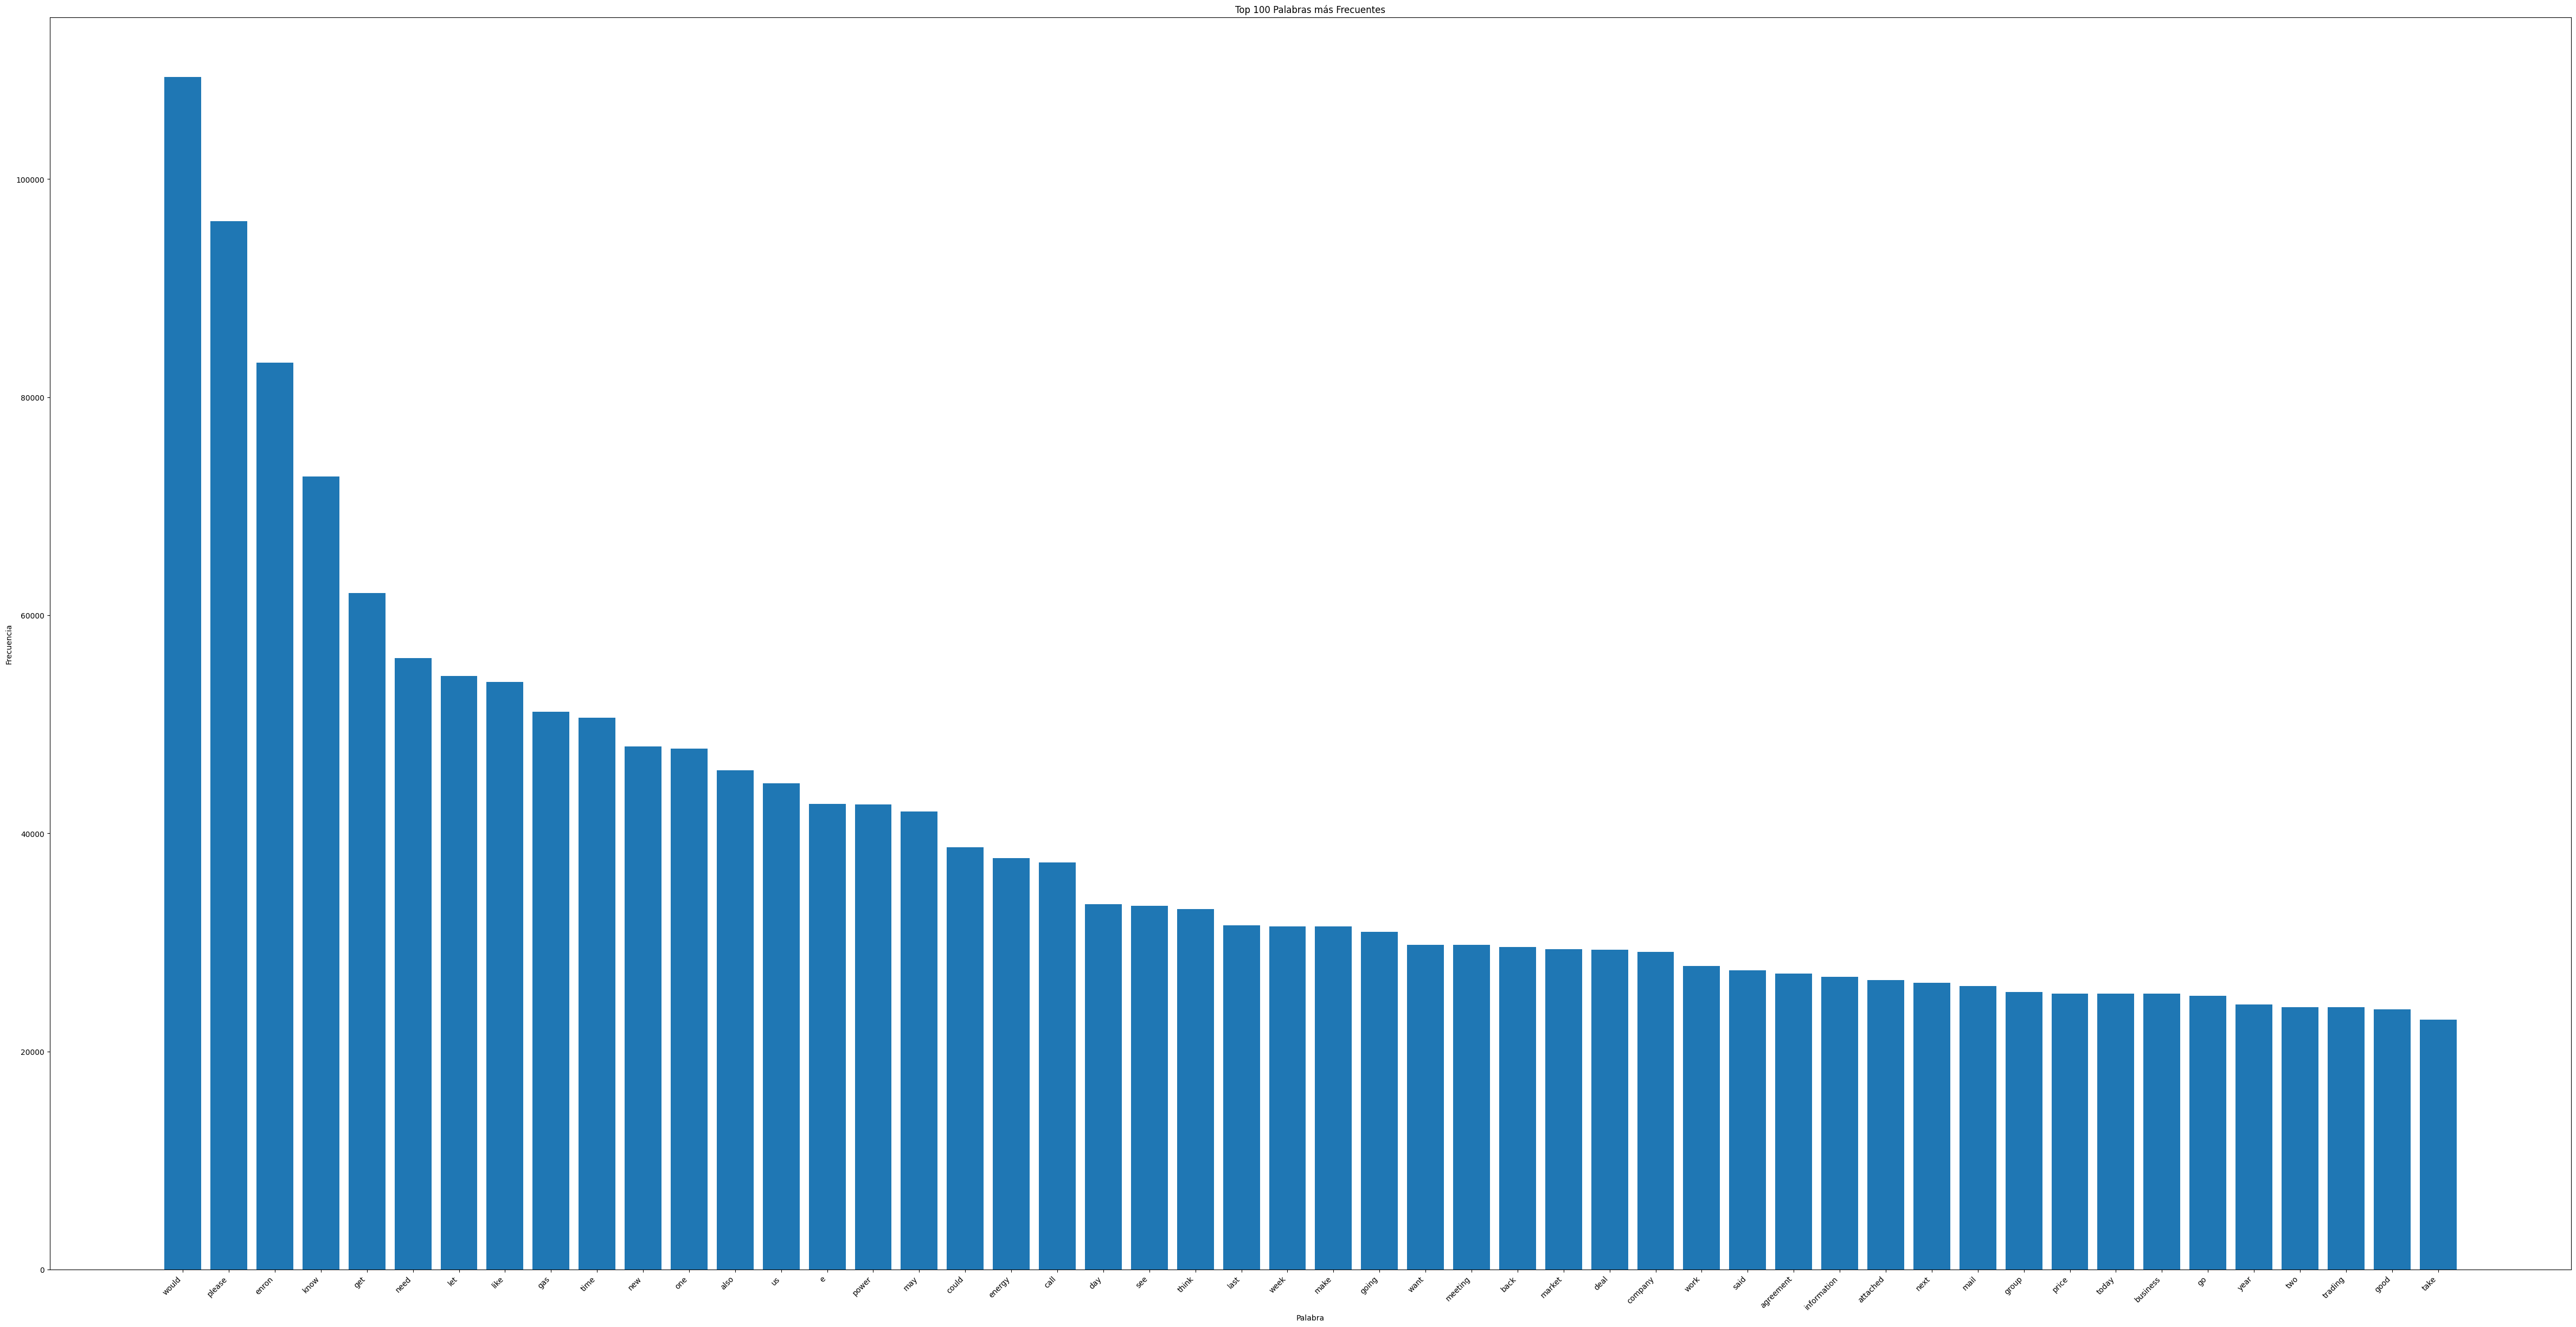

Matriz de Co-ocurrencia:
guess: 3219
know: 72728
tanked: 15
wonder: 780
really: 12067
conduct: 1051
illegal: 174
transactions: 7774
point: 11827
would: 109367
believe: 10174
anything: 10327
sucks: 326
employee: 4128
meeting: 29771
tomorrow: 12666
everyone: 7720
waiting: 2808
lay: 4165
say: 8715
two: 24057
dates: 3541
choose: 1448
december: 5278
fridays: 111
due: 11493
company: 29112
christmas: 1531
party: 10584
conflicts: 606
decided: 2900
houses: 292
heavy: 883
hors: 50
vours: 5
dessert: 116
drinks: 819
progressive: 33
dinner: 5334
format: 2589
takes: 2537
long: 14795
allow: 4607
us: 44613
actually: 5279
play: 3981
husbands: 30
please: 96120
email: 19197
date: 13544
preference: 704
get: 62046
back: 29584
chosen: 393
details: 4842
think: 33035
want: 29799
right: 14290
anyway: 3494
best: 10100
environment: 1446
besides: 639
hate: 697
houston: 17432
gotten: 1154
leads: 823
doucheboy: 1
h: 2025
r: 4132
guy: 3448
evaporated: 28
like: 53901
fart: 47
wind: 1728
must: 10082
realized: 543
unde

In [20]:
# Divide las palabras y sus frecuencias
words, frequencies = zip(*result_matrix.most_common(50))

plt.figure(figsize=(60, 30))
plt.bar(words, frequencies)
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.title('Top 100 Palabras más Frecuentes')
plt.xticks(rotation=45, ha='right')
plt.show()


# Matriz de co-ocurrencia
print("Matriz de Co-ocurrencia:")
for key, value in result_matrix.items():
    print(f"{key}: {value}")

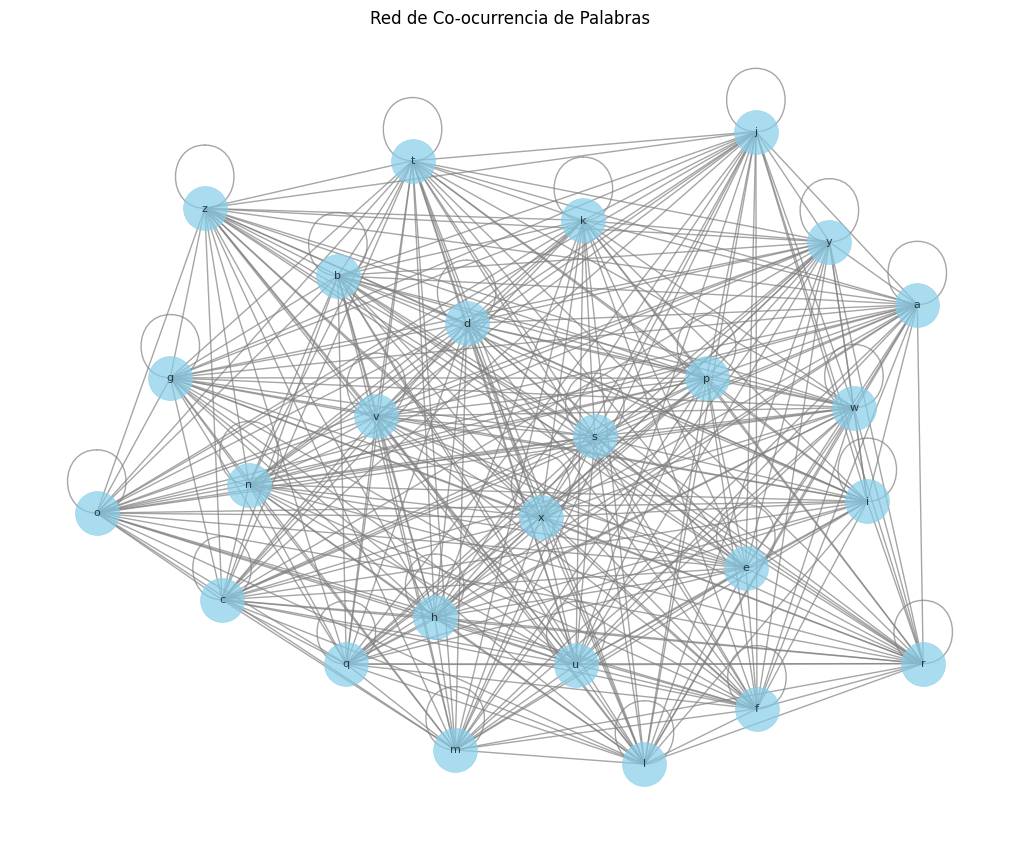

In [34]:
import networkx as nx
def visualize_word_network(result_matrix):
    G = nx.Graph()

    for words, weight in result_matrix.items():
        if len(words) >= 2:
            G.add_edge(words[0], words[1], weight=weight)
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  
    nx.draw(G, pos, with_labels=True, font_size=8, font_color='black', font_family='sans-serif', node_color='skyblue', edge_color='gray', linewidths=0.5, alpha=0.7, node_size=1000)
    plt.title('Red de Co-ocurrencia de Palabras')
    plt.show()
    
visualize_word_network(result_matrix)


### Comparativo entre palabras mas frecuentes y frecuencia del lematizador

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, ''),
  Text(1, 0, 'thanks'),
  Text(2, 0, 'pm'),
  Text(3, 0, 'fax'),
  Text(4, 0, 'vince'),
  Text(5, 0, 'jeff'),
  Text(6, 0, 'phone'),
  Text(7, 0, 'thank'),
  Text(8, 0, 'kay'),
  Text(9, 0, 'jim'),
  Text(10, 0, 'mark'),
  Text(11, 0, 'debra perlingiere'),
  Text(12, 0, 'fyi'),
  Text(13, 0, 'john'),
  Text(14, 0, 'carol st clair'),
  Text(15, 0, 'best'),
  Text(16, 0, 'mike'),
  Text(17, 0, 'chris'),
  Text(18, 0, 'pl'),
  Text(19, 0, 'kate'),
  Text(20, 0, 'doc'),
  Text(21, 0, 'kim'),
  Text(22, 0, 'houston tx'),
  Text(23, 0, 'tel'),
  Text(24, 0, 'carol'),
  Text(25, 0, 'eb'),
  Text(26, 0, 'steve'),
  Text(27, 0, 'sincerely'),
  Text(28, 0, 'cell'),
  Text(29, 0, 'ben'),
  Tex

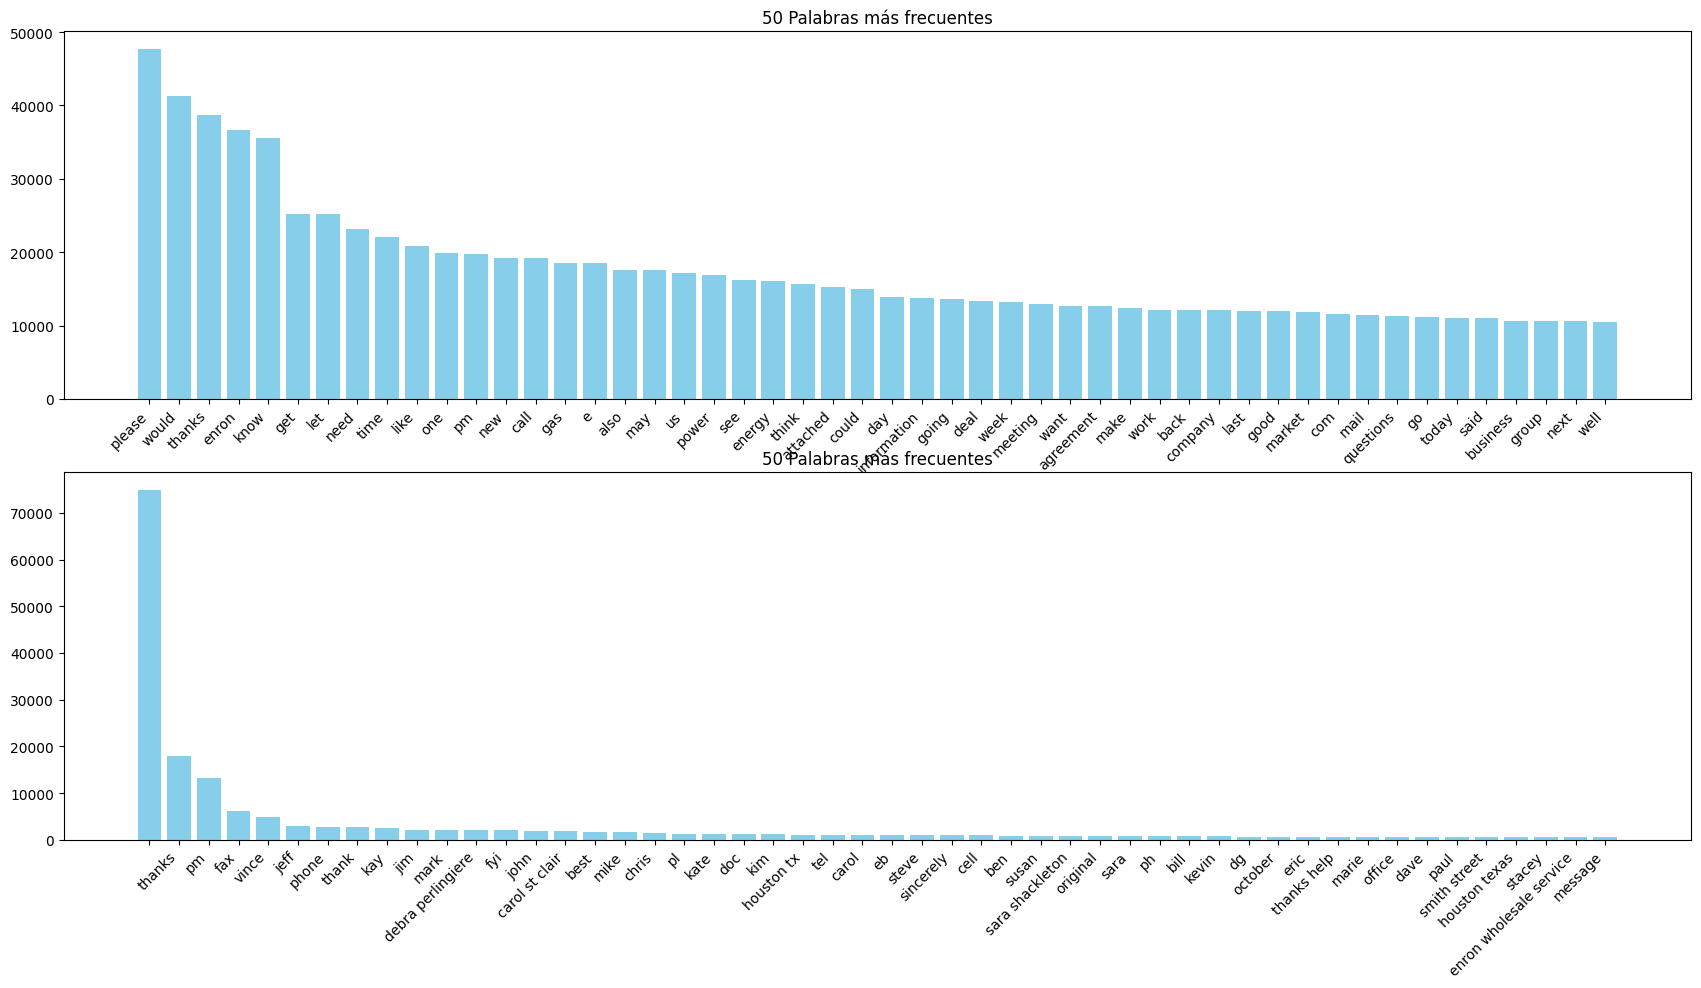

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(21, 10.5))

plt.subplot(211)
plt.bar(*zip(*word_frequency.most_common(50)), color='skyblue')
plt.title('50 Palabras más frecuentes')
plt.xticks(rotation=45, ha='right')

plt.subplot(212)
plt.bar(*zip(*word_counter.most_common(50)), color='skyblue')
plt.title('Top 50 frecuencia de lematizador')
plt.xticks(rotation=45, ha='right')

El uso del lematizador genera una diferencia notable para el analisis y da una perpectiva diferente a la del conteo de palabras. Este comparativo es de gran ayuda para generar un contexto, que permita implementar un sistema clasificador de solicitudes. 

#### Frecuenia de N- Gramas

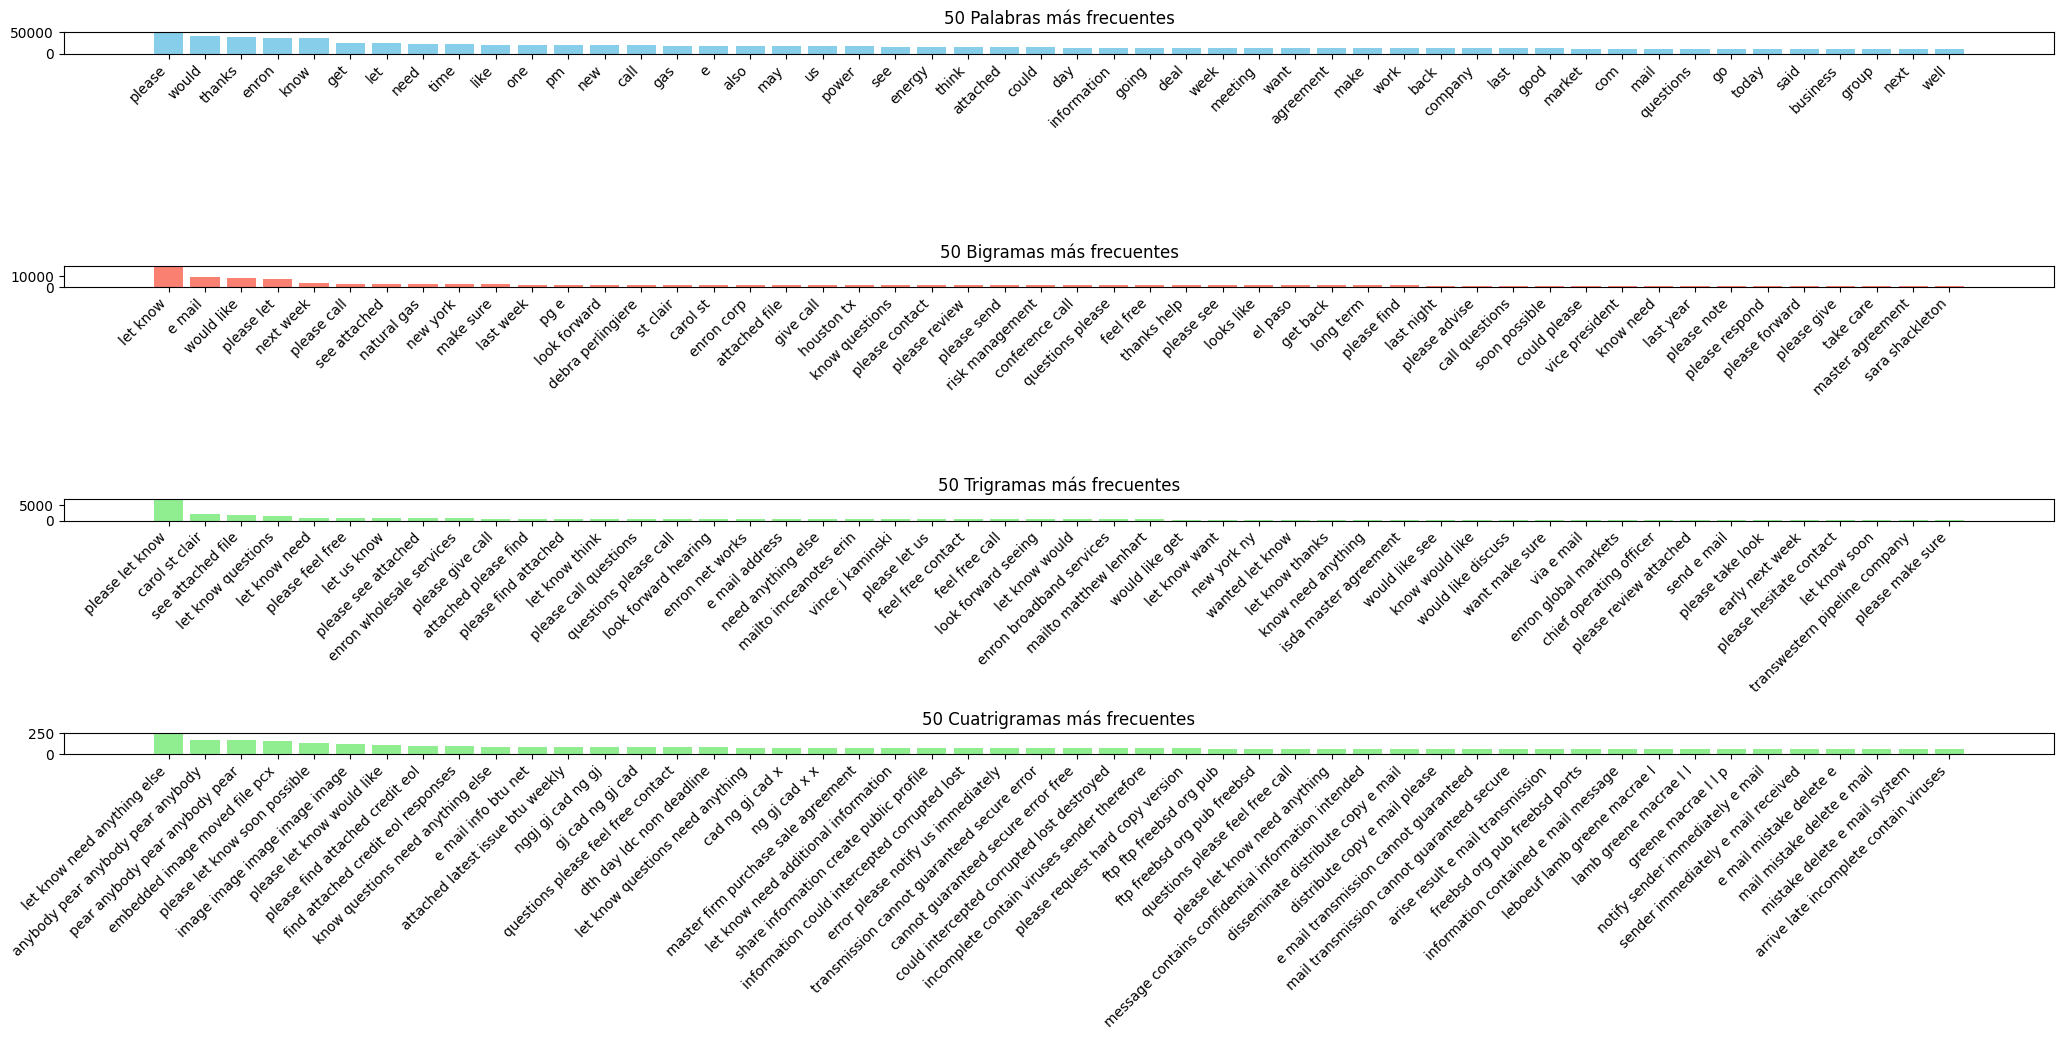

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(21, 10.5))

plt.subplot(411)
plt.bar(*zip(*word_frequency.most_common(50)), color='skyblue')
plt.title('50 Palabras más frecuentes')
plt.xticks(rotation=45, ha='right')

plt.subplot(412)
plt.bar(*zip(*bigram_frequency.most_common(50)), color='salmon')
plt.title('50 Bigramas más frecuentes')
plt.xticks(rotation=45, ha='right')

plt.subplot(413)
plt.bar(*zip(*trigram_frequency.most_common(50)), color='lightgreen')
plt.title('50 Trigramas más frecuentes')
plt.xticks(rotation=45, ha='right')

plt.subplot(414)
plt.bar(*zip(*ngram_frequency.most_common(50)), color='lightgreen')
plt.title('50 Pentagramas más frecuentes')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Como se menciono anteriormente, la interpretación de estas graficas son de gran ayuda para el trabajo de limpieza. Sin embargo aun habiendo realizado una depuración de información a limpiar se puede apreciar como aun sigue apareciendo información muy repetitiva que aparenta no se información objeto del analisis.

En lo pertinente a la continuación de este proyecto se avanzará con la información que ha este momento se tiene graficada, pero es importante tener en cuenta que si se puede realizar aun más limpieza en el texto los resultados mejoran drasticamente.

## Modelado

In [1]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
import time

start = time.time()

# train the model
model = Word2Vec([unique_words], vector_size=300, window=5, min_count=1, workers=4, sg=0)

# summarize the loaded model
print(model)
# save the model
model.wv.save_word2vec_format("email_embeddings.bin")

# load own word embeddings
email_embeddings = KeyedVectors.load_word2vec_format("email_embeddings.bin")

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((len(unique_words), 300))
count = 0

for i, word in enumerate(unique_words):
    if word in email_embeddings.key_to_index:
        embedding_vector = email_embeddings.get_vector(word)
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    else:
        count += 1

end = time.time()

print(f"Number of words not found in the embeddings: {count}")
print("Shape of embedding matrix:", embedding_matrix.shape)
print(f"Training time: {end - start} seconds")